<a href="https://colab.research.google.com/github/FelipeSotoG/U-Net-ResNetBlocks/blob/main/Resnet_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Descarga datos
Los datos se encuentran en el drive, por lo que usara gdown para sacarlos directamente y no tener que hacer la coneccion, ya que estamos descargando un zip.

In [1]:
!gdown https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt

Downloading...
From: https://drive.google.com/uc?id=1f3hc0IdnyN60NjGoPO9Za9Vnmj9pk3zt
To: /content/input.zip
100% 597M/597M [00:05<00:00, 105MB/s]


In [2]:
!unzip input.zip

Streaming output truncated to the last 5000 lines.
  inflating: input/train/masks/coronacases_007_177.png  
  inflating: input/train/masks/coronacases_004_104.png  
  inflating: input/train/masks/coronacases_005_202.png  
  inflating: input/train/masks/coronacases_006_128.png  
  inflating: input/train/masks/coronacases_008_12.png  
  inflating: input/train/masks/coronacases_009_51.png  
  inflating: input/train/masks/coronacases_004_230.png  
  inflating: input/train/masks/coronacases_010_237.png  
  inflating: input/train/masks/radiopaedia_10_85902_3_224.png  
  inflating: input/train/masks/radiopaedia_10_85902_3_297.png  
  inflating: input/train/masks/coronacases_006_23.png  
  inflating: input/train/masks/radiopaedia_29_86490_1_31.png  
  inflating: input/train/masks/coronacases_007_216.png  
  inflating: input/train/masks/coronacases_009_127.png  
  inflating: input/train/masks/coronacases_010_22.png  
  inflating: input/train/masks/coronacases_003_52.png  
  inflating: input/tra

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [4]:
import nibabel as nib
import os
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
import cv2
import torch

In [5]:
import imageio as iio
import glob
from skimage.transform import resize
src="/content/input/train"
imag="/images/"
X=np.zeros((len(glob.glob(src+imag+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+imag+"*.png"))):
  X[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)
mas="/masks/"
Y=np.zeros((len(glob.glob(src+mas+"*.png")),IMG_WIDTH,IMG_HEIGHT,1))
for i,x in enumerate(sorted(glob.glob(src+mas+"*.png"))):
  Y[i]=resize(iio.imread(x),(IMG_WIDTH,IMG_HEIGHT,1),mode="constant",preserve_range=True)/255

##Borrar directorio /input en caso de error

In [ ]:
!rm -r /content/input

##Train Test Split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=2)

##Resnet

In [35]:
def DiceMetric(y_true, y_pred):
  smooth=1e-6 
  gama=2
  y_true, y_pred = tf.cast(
      y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
  nominator = 2 * \
      tf.reduce_sum(tf.multiply(y_pred, y_true)) + smooth
  denominator = tf.reduce_sum(
      y_pred ** gama) + tf.reduce_sum(y_true ** gama) + smooth
  result = tf.divide(nominator, denominator)
  return result
def DiceLoss(y_true, y_pred):
      result= 1- DiceMetric(y_true, y_pred)
      return result

In [7]:
def conv_block(X,f,d=0.1,group=1):
  c = tf.keras.layers.Conv2D(f[0], (2, 2), activation='relu', kernel_initializer='he_normal', padding='same',groups=group)(X)
  #c = tf.keras.layers.BatchNormalization(axis=3)(c)
  c = tf.keras.layers.Dropout(d)(c)
  c = tf.keras.layers.Conv2D(f[1], (2, 2), kernel_initializer='he_normal', padding='same')(c)
  #c = tf.keras.layers.BatchNormalization(axis=3)(c)
  s = tf.keras.layers.Conv2D(f[1], (2, 2), kernel_initializer='he_normal', padding='same')(X)
  #s = tf.keras.layers.BatchNormalization(axis=3)(s)
  c = tf.keras.layers.Add()([c,s])
  c = tf.keras.layers.ReLU()(c)
  return c

In [38]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#s= inputs
#Contraction path
c1 = conv_block(s,[16,16])
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2 = conv_block(p1,[32,32])
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2,[64,64])
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = conv_block(p3,[128,128])
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = conv_block(p4,[256,256])

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = conv_block(u6,[128,128])
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = conv_block(u7,[64,64])
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = conv_block(u8,[32,32])

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = conv_block(u9,[16,16])
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_6 (Lambda)              (None, 128, 128, 1)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_168 (Conv2D)            (None, 128, 128, 16  80          ['lambda_6[0][0]']               
                                )                                                                 
                                                                                            

###Resnet con DiceLoss

In [36]:
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
#s= inputs
#Contraction path
c1 = conv_block(s,[16,16])
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2 = conv_block(p1,[32,32])
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2,[64,64])
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = conv_block(p3,[128,128])
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = conv_block(p4,[256,256])

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = conv_block(u6,[128,128])
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = conv_block(u7,[64,64])
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = conv_block(u8,[32,32])

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = conv_block(u9,[16,16])
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=DiceLoss, metrics=['accuracy',DiceMetric])
#model.compile(optimizer='adam', loss=DiceLoss, metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_5 (Lambda)              (None, 128, 128, 1)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_140 (Conv2D)            (None, 128, 128, 16  80          ['lambda_5[0][0]']               
                                )                                                                 
                                                                                            

##Model Fit

In [39]:
model.fit(X_train,Y_train,batch_size=16,epochs=25,validation_split=0.2)

Epoch 1/25
124/124 [==============================] - 9s 47ms/step - loss: 0.0579 - accuracy: 0.9843 - DiceMetric: 0.0874 - val_loss: 0.0422 - val_accuracy: 0.9855 - val_DiceMetric: 0.2027
Epoch 2/25
124/124 [==============================] - 5s 42ms/step - loss: 0.0302 - accuracy: 0.9871 - DiceMetric: 0.2034 - val_loss: 0.0312 - val_accuracy: 0.9854 - val_DiceMetric: 0.3571
Epoch 3/25
124/124 [==============================] - 5s 42ms/step - loss: 0.0245 - accuracy: 0.9872 - DiceMetric: 0.3734 - val_loss: 0.0297 - val_accuracy: 0.9861 - val_DiceMetric: 0.5375
Epoch 4/25
124/124 [==============================] - 5s 42ms/step - loss: 0.0191 - accuracy: 0.9877 - DiceMetric: 0.5579 - val_loss: 0.0178 - val_accuracy: 0.9868 - val_DiceMetric: 0.6626
Epoch 5/25
124/124 [==============================] - 5s 42ms/step - loss: 0.0143 - accuracy: 0.9884 - DiceMetric: 0.7061 - val_loss: 0.0153 - val_accuracy: 0.9872 - val_DiceMetric: 0.7720
Epoch 6/25
124/124 [==============================] - 5

In [ ]:
scores= model.evaluate(X_test, Y_test, verbose=0)
print(f'Score for fold {0}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
print(model.metrics_names)

Score for fold 0: loss of 0.08832569420337677; accuracy of 98.95649552345276%
['loss', 'accuracy', 'mean_io_u_10']


In [ ]:
print(model.metrics_names)

['loss', 'accuracy', 'mean_io_u_3']


##Testing

In [30]:
Ypred=model.predict(X_test)

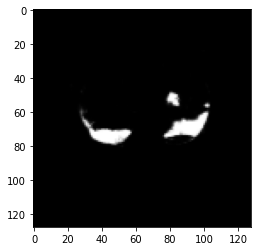

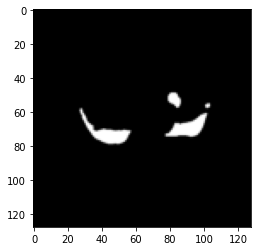

In [31]:
plt.imshow(np.reshape(Ypred[160],(128,128)), cmap=plt.cm.gray)
plt.show()
plt.imshow(np.reshape(Y_test[160],(128,128)), cmap=plt.cm.gray)
plt.show()

In [10]:
def dice(true_mask, pred_mask):
    """
        Computes the Dice coefficient.
        Args:
            true_mask : Array of arbitrary shape.
            pred_mask : Array with the same shape than true_mask.  
        
        Returns:
            A scalar representing the Dice coefficient between the two segmentations. 
        
    """
    non_seg_score=1.0
    if type(pred_mask) != np.ndarray:
      t = torch.Tensor([0.5])
      pred_mask=(pred_mask > t)
    else:
      pred_mask[pred_mask>=0.5]=1
      pred_mask[pred_mask<0.5]=0

    # If both segmentations are all zero, the dice will be 1. (Developer decision)
    im_sum = true_mask.sum() + pred_mask.sum()
    if im_sum == 0:
        return non_seg_score

    # Compute Dice coefficient
    intersection = np.logical_and(true_mask, pred_mask)
    return 2. * intersection.sum() / im_sum

In [32]:
diceaux=dice(Y_test[160],Ypred[160])
diceaux

0.9978291742992644

## Model Fit Kfold

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd

In [42]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)

In [45]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
nfold=1
for train_index, val_index in cv.split(X,Y):
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',DiceMetric])

  X_fold=X[train_index,:,:]
  Y_fold=Y[train_index,:,:]
  
  model.fit(X_fold,Y_fold,batch_size=16,epochs=25,validation_split=0.2,verbose=0)

  Xtest_fold=X[val_index,:,:]
  Ytest_fold=Y[val_index,:,:]
  scores= model.evaluate(Xtest_fold, Ytest_fold, verbose=0)
  print(f'Score for fold {nfold}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% {model.metrics_names[2]} of {scores[2]*100}%')
  nfold+=1

Score for fold 1: loss of 0.021185964345932007; accuracy of 98.92821907997131% DiceMetric of 87.15552687644958%
Score for fold 2: loss of 0.03022151067852974; accuracy of 98.80168437957764% DiceMetric of 85.4077160358429%
Score for fold 3: loss of 0.040300868451595306; accuracy of 98.85856509208679% DiceMetric of 81.43382668495178%
Score for fold 4: loss of 0.03747517988085747; accuracy of 98.85780215263367% DiceMetric of 84.96236205101013%
Score for fold 5: loss of 0.04578666388988495; accuracy of 98.89907240867615% DiceMetric of 81.83032870292664%
